In [ ]:
import tensorflow as tf
from tensorflow.python.ops import rnn, rnn_cell
# from tensorflow.contrib.rnn.python.ops import rnn_cell
from tensorflow.contrib.grid_rnn.python.ops import grid_rnn_cell
import numpy as np


#define parameters
n_input_x = 10
n_input_y = 10
n_input_z = 10

n_hidden = 128
n_classes = 2

x = tf.placeholder("float", [n_input_x, n_input_y, n_input_z])
y = tf.placeholder("float", [n_input_x, n_input_y, n_input_z, n_classes])

#generate random data
input_data = np.random.rand(n_input_x, n_input_y, n_input_z)
ground_truth = np.random.rand(n_input_x, n_input_y, n_input_z, n_classes)

#build GridLSTM
# from https://github.com/KendallWeihe/Tensorflow-GridRNNCell-example/blob/master/GridLSTM_ex.py
def GridLSTM_network(x):
    #import pdb
    #pdb.set_trace()

    x = tf.reshape(x, [-1,n_input_x])
    x = tf.split(0, n_input_y * n_input_z, x)
    lstm_cell = grid_rnn_cell.GridRNNCell(n_hidden, num_dims=3)
    # lstm_cell = rnn_cell.GridLSTMCell(n_hidden, use_peepholes=True)
    lstm_cell = rnn_cell.MultiRNNCell([lstm_cell] * n_hidden, state_is_tuple=True)
    lstm_cell = rnn_cell.DropoutWrapper(lstm_cell, output_keep_prob=0.8)

    outputs, states = rnn.rnn(lstm_cell, x, dtype=tf.float32)

    return outputs

#initialize network, cost, optimizer and all variables
pred = GridLSTM_network(x)
pred = tf.pack(pred)
pred = tf.transpose(pred, [1,0,2,3])
temp_pred = tf.reshape(pred, [-1,n_classes])
temp_y = tf.reshape(y,[-1, n_classes])

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(temp_pred, temp_y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model
correct_pred = tf.equal(0,tf.cast(tf.sub(tf.nn.softmax(temp_pred),temp_y), tf.int32))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))


# Initializing the variables
init = tf.initialize_all_variables()

# Launch the graph
with tf.Session() as sess:
    sess.run(init)
    step = 0
    while 1:
        print(step)
        step = step + 1
        # pdb.set_trace
        sess.run(optimizer, feed_dict={x: input_data, y: ground_truth})


In [ ]:
#build GridLSTM
# from https://github.com/KendallWeihe/Tensorflow-GridRNNCell-example/blob/master/GridLSTM_ex.py
def GridLSTM_network(x keep_prob):
    #import pdb
    #pdb.set_trace()

    x = tf.reshape(x, [-1,n_input_x])
    x = tf.split(0, n_input_y * n_input_z, x)
    # lstm_cell = grid_rnn_cell.GridRNNCell(n_hidden, num_dims=3)
    lstm_cell = rnn_cell.GridLSTMCell(n_hidden, use_peepholes=True)
    lstm_cell = rnn_cell.MultiRNNCell([lstm_cell] * n_hidden, state_is_tuple=True)
    lstm_cell = rnn_cell.DropoutWrapper(lstm_cell, output_keep_prob=keep_prob)

    outputs, states = rnn.rnn(lstm_cell, x, dtype=tf.float32)

    return outputs

In [16]:
# convert an array of values into a dataset matrix
def create_dataset(trainX, trainY, look_back=1):
    dataX, dataY = [], []
    for i in range(len(trainX)-look_back-1):
        a = trainX[i:(i+look_back),:]
        dataX.append(a)
        dataY.append(trainY[i + look_back])
    return np.array(dataX), np.array(dataY)

In [110]:
from IPython.display import clear_output

# Live plot for loss during training
# Taken from: https://gist.github.com/stared/dfb4dfaf6d9a8501cd1cc8b8cb806d2e
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        #self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        #self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        #plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

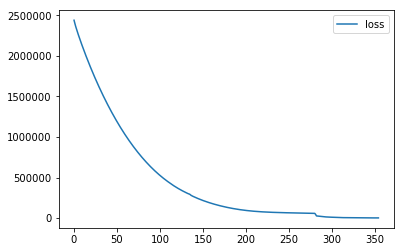

2072/2072 [==============================] - 0s - loss: 1737.8707     

In [ ]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM
import keras

# with tf.Session() as sess:
#         latent_val = hidden4.eval(feed_dict={X: x_train})

latent_val = pd.read_csv('sae_output_5000.csv')
latent_val = np.array(latent_val)
y_lazy = pd.read_csv('data/sp500_index_data.csv')['Close Price']
y_train = y_lazy.shift(-1)
y_train = np.array(y_train)

#mean_y = np.sum(y_train)/len(y_train)
#std_dev = np.sqrt(np.dot(y_train - mean_y, y_train - mean_y) / (len(y_train) - 1))
#y_train = (y_train - mean_y) / sqrt(y_train )

#this means we have an na for the last value training is latent_val, target y_train

look_back =4
trainX = latent_val[:-1]
#trainX = trainX[:round(0.9*len(trainX))]
#testX = trainX[round(0.9*len(trainX)):]

trainY = np.array(y_train[:-1])
#trainY = trainX[:round(0.9*len(trainY))]
#testY = trainX[round(0.9*len(trainY)):]

trainX, trainY = create_dataset(trainX, trainY, look_back)
#testX, testY = create_dataset(testX, testY, look_back) 

# create and fit the LSTM network
LEARNING_RATE = 0.05
BATCH_SIZE = 60
EPOCHS = 5000
opti_adam = keras.optimizers.Adam(lr=LEARNING_RATE, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model = Sequential()

model.add(LSTM(5, input_shape=(look_back, 10)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer=opti_adam)
model.fit(trainX, trainY, epochs=EPOCHS, batch_size=BATCH_SIZE,
          verbose=1, callbacks=[plot_losses])

[[ 1160.17236328]
 [ 1171.10302734]
 [ 1171.79467773]
 ..., 
 [ 2104.9453125 ]
 [ 2105.02246094]
 [ 2105.03833008]]


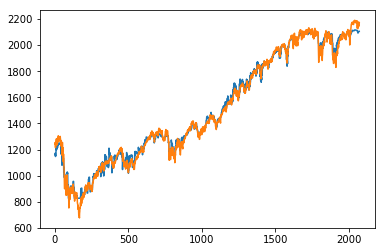

In [98]:
bugger = model.predict(trainX)
print(bugger)
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(bugger)
plt.plot(trainY)
plt.show()

2071
2071


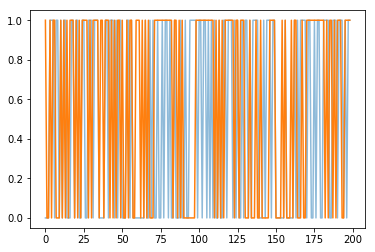

[ 1160.17236328  1171.10302734  1171.79467773 ...,  2104.9453125
  2105.02246094  2105.03833008]


In [99]:
diff_bugger = np.diff(bugger[:,0])
diff_bugger = [1 if x > 0 else 0 for x in diff_bugger]
diff_trainY = np.diff(trainY)
diff_trainY = [1 if x > 0 else 0 for x in diff_trainY]
print(len(diff_trainY))
print(len(diff_bugger))
plt.plot(diff_trainY[1:200], alpha = 0.5)
plt.plot(diff_bugger[1:200])
plt.show()
print(bugger[:,0])

In [100]:
from sklearn.metrics import confusion_matrix
confusion_matrix(diff_bugger, diff_trainY, labels=[0,1])

array([[437, 468],
       [511, 655]], dtype=int64)